In [7]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.linear_model import Ridge
import numpy as np


In [14]:
data = pd.read_csv("/home/pamalo9/zrive-ds/src/data/module_2/feature_frame.csv")

In [15]:
data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [17]:
# we have seen in EDA that it is a good idea label the columns in groups
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [
    'user_order_seq',
    'normalised_price',
    'discount_pct',
    'global_popularity',
    'count_adults',
    'count_children',
    'count_babies',
    'count_pets',
    'people_ex_baby',
    'days_since_purchase_variant_id',
    'avg_days_to_buy_variant_id',
    'std_days_to_buy_variant_id',
    'days_since_purchase_product_type',
    'avg_days_to_buy_product_type',
    'std_days_to_buy_product_type'
]

features_cols = categorical_cols + binary_cols + numerical_cols

In [18]:
# We only want the orders with 5 items
count_items = data.groupby('order_id')['outcome'].sum() 
special_orders = count_items >= 5  
data_filtered = data[data['order_id'].isin(special_orders[special_orders].index)]

In [19]:
#Just to ensure that it is correct
print(count_items[count_items >= 5].describe())

count    2603.000000
mean       12.035728
std         6.122365
min         5.000000
25%         8.000000
50%        11.000000
75%        15.000000
max        78.000000
Name: outcome, dtype: float64


In [20]:
data_filtered.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [21]:
#In EDA we have seen that It will be good to split the data temporally
# Sort by order_date
data_filtered['order_date'] = pd.to_datetime(data_filtered['order_date'])
data_filtered.sort_values(by='order_date', inplace=True)

# Define 70% train, 15% validation, 15% test
train_size = int(0.7 * len(data_filtered))
val_size = int(0.15 * len(data_filtered))

# Split the data
train_data = data_filtered[:train_size]
val_data = data_filtered[train_size:train_size+val_size]
test_data = data_filtered[train_size+val_size:]

print(f"Training data: \nFrom {train_data['order_date'].min()} to {train_data['order_date'].max()}")
print(f"Length of training data: {len(train_data)}\n")

print(f"Validation data: \nFrom {val_data['order_date'].min()} to {val_data['order_date'].max()}")
print(f"Length of validation data: {len(val_data)}\n")

print(f"Test data: \nFrom {test_data['order_date'].min()} to {test_data['order_date'].max()}")
print(f"Length of test data: {len(test_data)}")




/tmp/ipykernel_47256/3410492329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['order_date'] = pd.to_datetime(data_filtered['order_date'])


Training data: 
From 2020-10-05 00:00:00 to 2021-02-09 00:00:00
Length of training data: 1514767

Validation data: 
From 2021-02-09 00:00:00 to 2021-02-20 00:00:00
Length of validation data: 324592

Test data: 
From 2021-02-20 00:00:00 to 2021-03-03 00:00:00
Length of test data: 324594


/tmp/ipykernel_47256/3410492329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.sort_values(by='order_date', inplace=True)


In [22]:
train_data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2491847,33667182035076,shavinggrooming,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2491846,33667182035076,shavinggrooming,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2491845,33667182035076,shavinggrooming,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
394015,33667209199748,dishwasherdetergent,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947


In [23]:
val_data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
2084070,33667229122692,babytoiletries,2918273810564,3872153174148,2021-02-09 21:46:16,2021-02-09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,52.0,29.852016,30.0,36.0,29.372186
2084069,33667229122692,babytoiletries,2918269583492,3813524471940,2021-02-09 21:38:57,2021-02-09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,52.0,29.852016,30.0,36.0,29.372186
2084067,33667229122692,babytoiletries,2918253953156,3902193664132,2021-02-09 21:13:43,2021-02-09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,52.0,29.852016,30.0,36.0,29.372186
55615,34037941862532,kitchenrolltissues,2918084575364,3785431056516,2021-02-09 16:55:13,2021-02-09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,38.5,28.704341,30.0,30.0,24.688701
55616,34037941862532,kitchenrolltissues,2918095814788,3909197529220,2021-02-09 17:10:55,2021-02-09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,38.5,28.704341,30.0,30.0,24.688701


In [24]:
test_data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
1827166,34086451347588,handsoapsanitisers,2926542815364,3218344935556,2021-02-20 15:00:16,2021-02-20,13,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,50.5,33.970637,64.0,33.0,27.961179
1827164,34086451347588,handsoapsanitisers,2926525939844,3769205227652,2021-02-20 14:24:52,2021-02-20,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,50.5,33.970637,30.0,33.0,27.961179
1827163,34086451347588,handsoapsanitisers,2926517846148,3853496221828,2021-02-20 14:08:37,2021-02-20,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,50.5,33.970637,30.0,33.0,27.961179
1827162,34086451347588,handsoapsanitisers,2926511095940,3907377070212,2021-02-20 13:52:24,2021-02-20,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,50.5,33.970637,30.0,33.0,27.961179
1995053,33667236364420,catfood,2926794440836,3865466929284,2021-02-20 22:02:50,2021-02-20,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,28.0,32.004185,30.0,27.0,27.212938


- Now we have seen that It will be a good idea start with a baseline. Later we will need to create a model that beats the baseline.
- Tradeoff between sending too many push notifications and increase sales


AUC-ROC: 0.7857268531732279


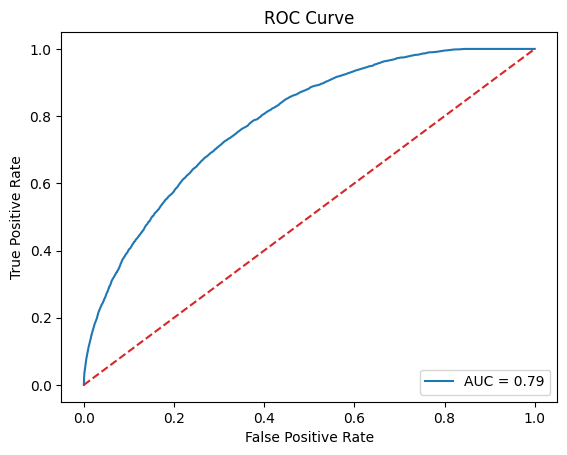

In [25]:
# I will use global_popularity as baseline
y_true = val_data[label_col]
y_probs = val_data['global_popularity']

# Calculate AUC
auc_roc = roc_auc_score(y_true, y_probs)
print(f"AUC-ROC: {auc_roc}")

# Calculate curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % auc_roc)
plt.plot([0, 1], [0, 1], color='C3', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

AUC PR: 0.06790596312849964


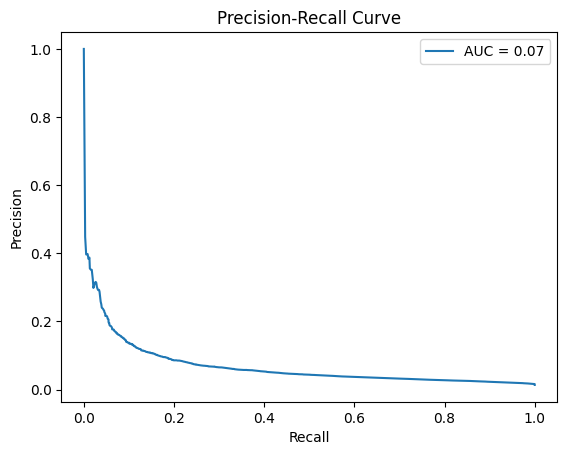

In [26]:

precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
auc_pr = average_precision_score(y_true, y_probs)
print(f"AUC PR: {auc_pr}")

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, label='AUC = %0.2f' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

 I will create a function for this later

In [27]:
data_filtered['outcome'].value_counts()

outcome
0.0    2132624
1.0      31329
Name: count, dtype: int64

- We have a very unbalanced problem, We will need to take this into account when interpreting the results on the ROC and PR curves. The ROC curve will give us unreliable data due to the sensitivity on the false positive rate. Better to look at the predictive power of the PR plot.
- We need to create plots for the model with different alpha and for the baseline, It will be a good idea to create a function to create the ROC curve and the P-R curve.

 RIDGE MODEL

In [28]:
# Take the numerical columns to train the model
numeric_binary_cols = numerical_cols + binary_cols

X_train = train_data[numeric_binary_cols]
y_train = train_data[label_col]

X_val = val_data[numeric_binary_cols]
y_val = val_data[label_col]

X_test = test_data[numeric_binary_cols]
y_test = test_data[label_col]

In [29]:
# Create roc and precision-recall functions
def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc_roc = roc_auc_score(y_true, y_probs)
    plt.plot([0, 1], [0, 1], color='C3', linestyle='--')
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = %0.2f)' % auc_roc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

def plot_precision_recall_curve(y_true, y_probs, model_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    auc_pr = average_precision_score(y_true, y_probs)
    
    plt.plot(recall, precision, label=f'{model_name} (AUC = %0.2f)' % auc_pr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')

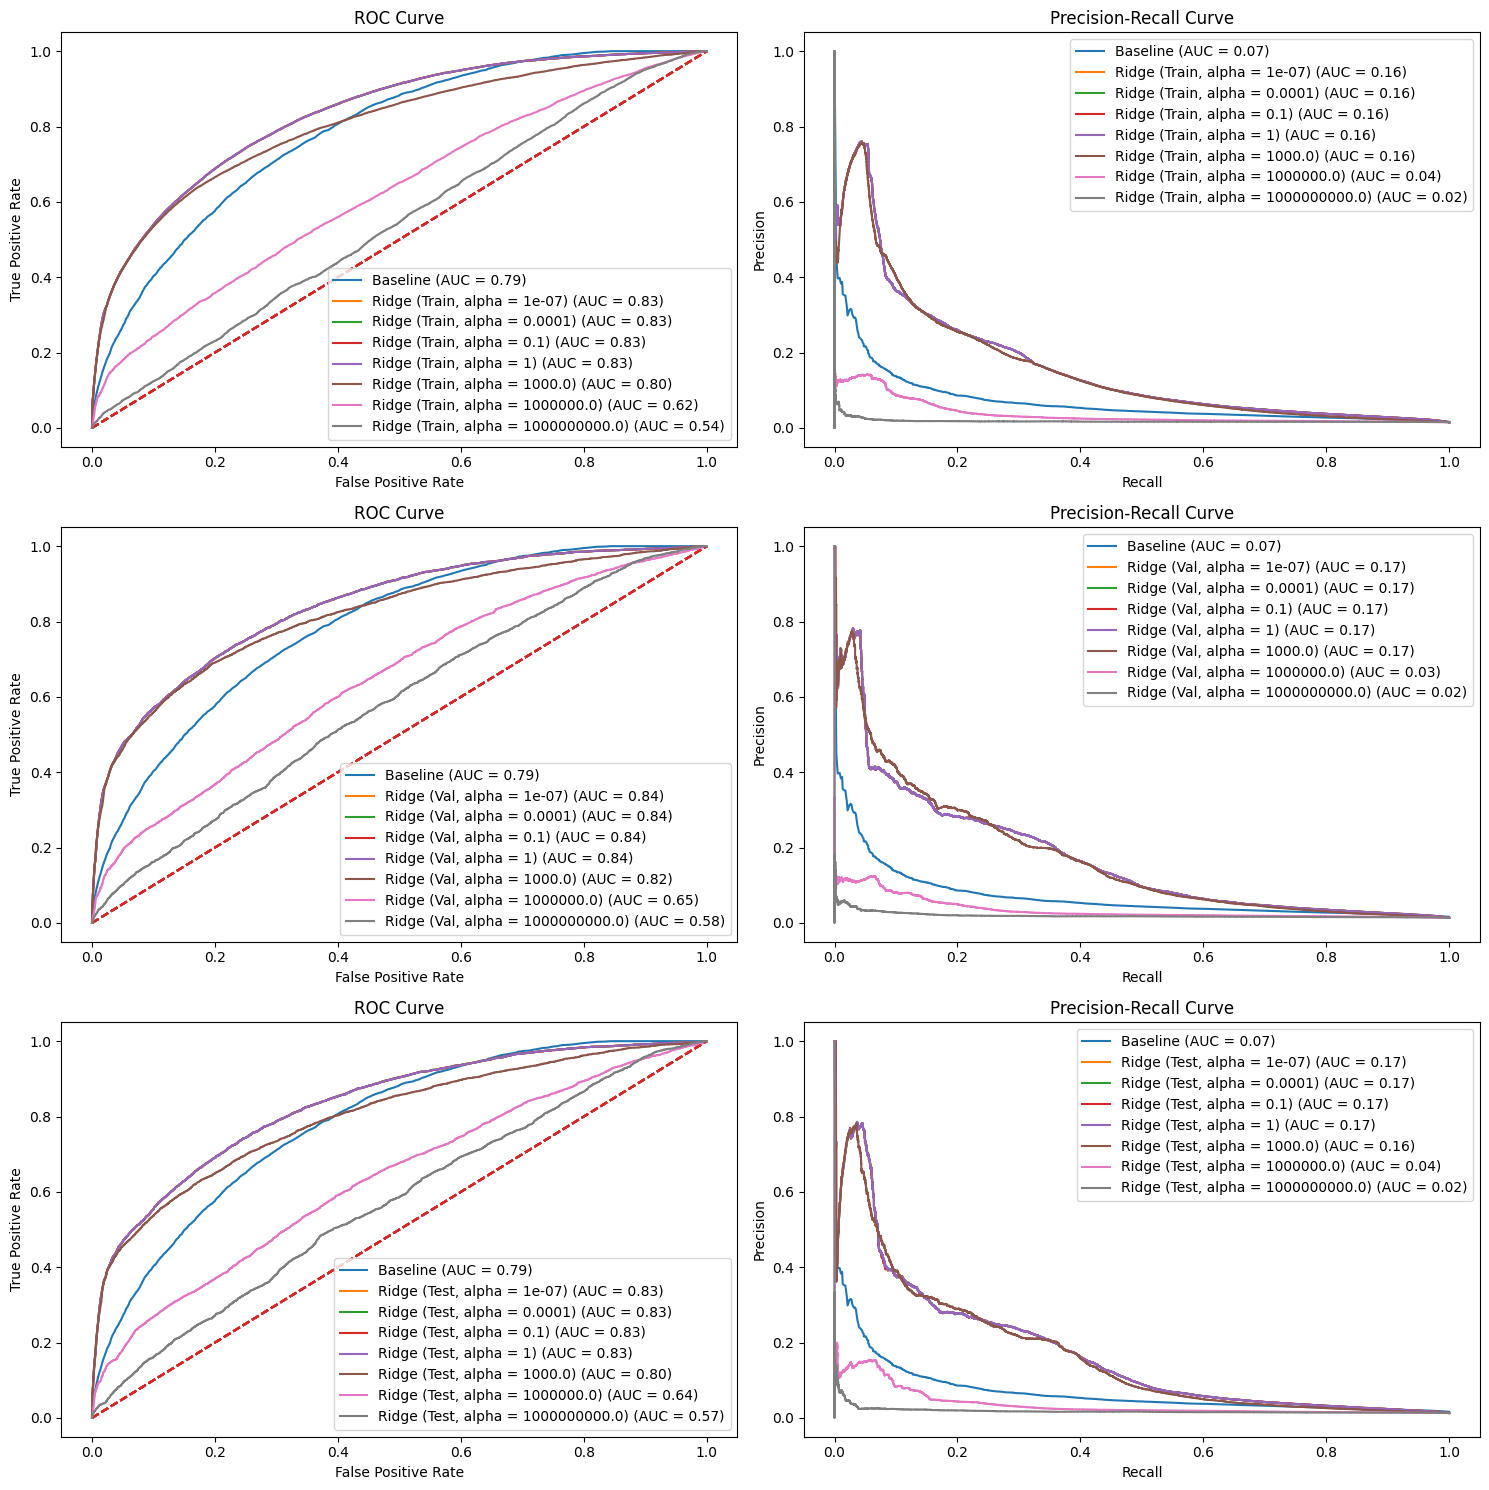

In [30]:
# Define some alphas
alphas = [1e-7, 1e-4, 1e-1, 1, 1e3, 1e6, 1e9 ]

#For the baseline
y_true = val_data[label_col]
y_probs = val_data['global_popularity']

# Figure
plt.figure(figsize=(15,15))

# Baseline
for i in range(1, 7):
    plt.subplot(3, 2, i)
    if i % 2 == 1:
        plot_roc_curve(y_true, y_probs, 'Baseline')
    else:
        plot_precision_recall_curve(y_true, y_probs, 'Baseline')

for alpha in alphas:
    # train the model
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    
    y_train_probs_ridge = ridge_model.predict(X_train)
    y_val_probs_ridge = ridge_model.predict(X_val)
    y_test_probs_ridge = ridge_model.predict(X_test)
    

    # ROC for train
    plt.subplot(3, 2, 1)
    plot_roc_curve(y_train, y_train_probs_ridge, f'Ridge (Train, alpha = {alpha})')

    # Precision-recall for train
    plt.subplot(3, 2, 2)
    plot_precision_recall_curve(y_train, y_train_probs_ridge, f'Ridge (Train, alpha = {alpha})')
    

    # ROC for val
    plt.subplot(3, 2, 3)
    plot_roc_curve(y_val, y_val_probs_ridge, f'Ridge (Val, alpha = {alpha})')
   
    # Precision-recall for val
    plt.subplot(3, 2, 4)
    plot_precision_recall_curve(y_val, y_val_probs_ridge, f'Ridge (Val, alpha = {alpha})')
  

    # ROC for test
    plt.subplot(3, 2, 5)
    plot_roc_curve(y_test, y_test_probs_ridge, f'Ridge (Test, alpha = {alpha})')
   
    # Precision-recall for test
    plt.subplot(3, 2, 6)
    plot_precision_recall_curve(y_test, y_test_probs_ridge, f'Ridge (Test, alpha = {alpha})')
   
plt.tight_layout()



- We can see that the train and the validation is very similar, It is a signal of not overfiting
- If we take very high alpha values, the model behaves worse. It behaves like a random, 0 predictive power. Worse than baseline
- Good alpha: 1e3

Text(0.5, 1.0, 'Importance of columns')

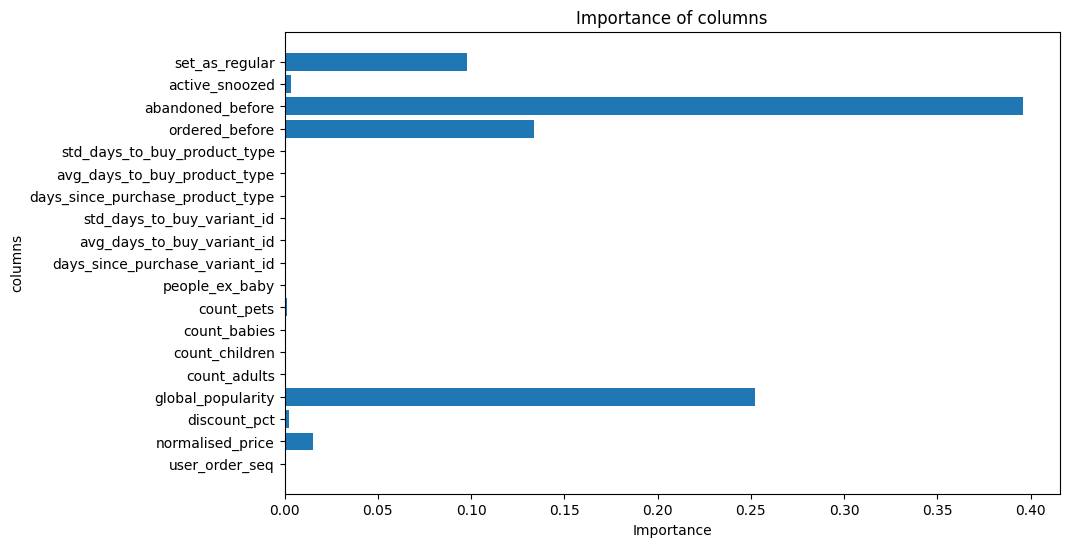

In [31]:
#This alpha makes that the model works well
alpha = 1e3

# specific alpha
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)

coeficientes = ridge_model.coef_

weight = np.abs(coeficientes)

plt.figure(figsize=(10, 6))
plt.barh(numeric_binary_cols, weight)
plt.xlabel('Importance')
plt.ylabel('columns')
plt.title('Importance of columns')